# Motif Logo Plot
The purpose of this notebook is to generate a motif logo plot for both Donor and Acceptor from human sequencing file and a gene definition file.

## Load packages 

In [ ]:
import random
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import logomaker

## 1. Multi Fasta simulation

In [56]:
# Parameters
num_sequences = 1000
seq_length = 100
output_path = '/Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_sequences.fasta'
bases = ['A', 'C', 'G', 'T']

# Generate and write multi-FASTA
with open(output_path, 'w') as fasta:
    for i in range(1, num_sequences + 1):
        seq = ''.join(random.choices(bases, k=seq_length))
        fasta.write(f">seq{i}\n{seq}\n")

print(f"Generated {num_sequences} sequences of length {seq_length} in {output_path}")

Generated 1000 sequences of length 100 in /Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_sequences.fasta


## 2. GTF simulation

In [63]:
num_sequences = 1000
contig_length = 100   # must match your FASTA seq_length
min_exon, max_exon = 10, 25
buffer = 5            # minimum intronic buffer between exons

# First, choose “consensus” exon lengths and positions:
cons_len1 = random.randint(min_exon, max_exon)
cons_len2 = random.randint(min_exon, max_exon)
# place consensus exon1 near the 5' end
cons_start1 = random.randint(1, contig_length - cons_len1 - cons_len2 - buffer)
cons_end1   = cons_start1 + cons_len1 - 1
# place consensus exon2 after exon1 + buffer
cons_start2 = random.randint(cons_end1 + buffer, contig_length - cons_len2 + 1)
cons_end2   = cons_start2 + cons_len2 - 1

gtf_path = '/Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_mixed_strand.gtf'
with open(gtf_path, 'w') as gtf:
    for i in range(1, num_sequences + 1):
        chrom  = f"seq{i}"
        strand = '+' if i % 2 == 1 else '-'
        
        # 90% use consensus coords; 10% random
        if random.random() < 0.9:
            start1, end1 = cons_start1, cons_end1
            start2, end2 = cons_start2, cons_end2
        else:
            # random lengths between 10–20
            len1 = random.randint(min_exon, max_exon)
            len2 = random.randint(min_exon, max_exon)
            # random placements with buffer
            start1 = random.randint(1, contig_length - len1 - len2 - buffer)
            end1   = start1 + len1 - 1
            start2 = random.randint(end1 + buffer, contig_length - len2 + 1)
            end2   = start2 + len2 - 1
        
        # write exons
        gtf.write(
            f"{chrom}\tmyAnno\texon\t{start1}\t{end1}\t.\t{strand}\t.\t"
            f"gene_id \"GENE{i}\"; transcript_id \"TX{i}\";\n"
        )
        gtf.write(
            f"{chrom}\tmyAnno\texon\t{start2}\t{end2}\t.\t{strand}\t.\t"
            f"gene_id \"GENE{i}\"; transcript_id \"TX{i}\";\n"
        )

print(f"Written 90%‑consensus GTF to {gtf_path}")


# Display a sample of the generated GTF
gtf_sample = pd.read_csv(gtf_path, sep='\t', header=None, nrows=6)
gtf_sample

Written 90%‑consensus GTF to /Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_mixed_strand.gtf


,0,1,2,3,4,5,6,7,8
0,seq1,myAnno,exon,27,51,.,+,.,"gene_id ""GENE1""; transcript_id ""TX1"";"
1,seq1,myAnno,exon,76,99,.,+,.,"gene_id ""GENE1""; transcript_id ""TX1"";"
2,seq2,myAnno,exon,27,51,.,-,.,"gene_id ""GENE2""; transcript_id ""TX2"";"
3,seq2,myAnno,exon,76,99,.,-,.,"gene_id ""GENE2""; transcript_id ""TX2"";"
4,seq3,myAnno,exon,27,51,.,+,.,"gene_id ""GENE3""; transcript_id ""TX3"";"
5,seq3,myAnno,exon,76,99,.,+,.,"gene_id ""GENE3""; transcript_id ""TX3"";"


## 3. Plot logo

### 3.1 Infer splice site and create PTM for Donor and Acceptor

In [64]:
# Manual FASTA parsing
def load_fasta(path):
    seqs = {}
    with open(path) as f:
        header = None
        lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if header:
                    seqs[header] = ''.join(lines)
                header = line[1:]
                lines = []
            else:
                lines.append(line)
        if header:
            seqs[header] = ''.join(lines)
    return seqs

# Reverse complement function
def revcomp(seq):
    comp = str.maketrans('ACGT', 'TGCA')
    return seq.translate(comp)[::-1]

# Paths
fasta_path = '/Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_sequences.fasta'
gtf_path = '/Users/kaiyuchen/Desktop/Analysis/cancer/StJude_CG/data/simulated_mixed_strand.gtf'

# Load simulated genome
genome = load_fasta(fasta_path)

# Parse GTF and extract sequences
donor_seqs = []
acceptor_seqs = []

transcripts = {}
with open(gtf_path) as gtf:
    for line in gtf:
        if line.startswith('#') or not line.strip():
            continue
        chrom, src, feat, start, end, score, strand, frame, attrs = line.split('\t')
        start, end = int(start), int(end)
        tx_id = attrs.split('transcript_id')[1].split('"')[1]
        transcripts.setdefault(tx_id, []).append((chrom, strand, start, end))

for tx_id, exons in transcripts.items():
    # sort exons by coordinate
    strand = exons[0][1]
    exons_sorted = sorted(exons, key=lambda x: x[2], reverse=(strand=='-'))
    for e1, e2 in zip(exons_sorted, exons_sorted[1:]):
        chrom, strand, s1, e1_pos = e1
        _, _, s2, e2_pos = e2
        intron_start = e1_pos + 1
        intron_end = s2 - 1
        # donor: last3 exon + first9 intron
        d = genome[chrom][e1_pos-3:e1_pos] + genome[chrom][intron_start-1:intron_start+8]
        # acceptor: last9 intron + first3 exon
        a = genome[chrom][intron_end-9:intron_end] + genome[chrom][s2-1:s2+2]
        if strand == '-':
            d = revcomp(d)
            a = revcomp(a)
        donor_seqs.append(d)
        acceptor_seqs.append(a)

In [73]:
# Suppose we already have:
#   donor_seqs    = [ ’CAGGTAAGTCAA’, ... ]
#   acceptor_seqs = [ ’CCCCCCCCCAGT’, ... ]

# 1) Find donor_up by locating the GT boundary
#    We scan each possible split i (1…L-1) and score how many sequences have
#    s[i]=='G' and s[i+1]=='T'. Pick the split with the highest support.

def infer_split(seqs, motif):
    L = len(seqs[0])
    best_i, best_count = None, -1
    for i in range(L-1):
        cnt = sum(1 for s in seqs if s[i:i+2] == motif)
        if cnt > best_count:
            best_i, best_count = i, cnt
    return best_i

def build_pfm(seqs):
    L = len(seqs[0])
    bases = ['A','C','G','T']
    mat = np.zeros((L,4), int)
    for s in seqs:
        for i, b in enumerate(s):
            if b in bases:
                mat[i, bases.index(b)] += 1
    return pd.DataFrame(mat, columns=bases)

donor_up = infer_split(donor_seqs, "GT")      
donor_down = len(donor_seqs[0]) - donor_up

acceptor_split = infer_split(acceptor_seqs, "AG") 
# That i is the last intron position (i.e. acceptor_up = i+1), so:
acceptor_up   = infer_split(acceptor_seqs, "AG") + 1
acceptor_down = len(acceptor_seqs[0]) - acceptor_up

# 2) Build relative‐position indices
donor_positions    = list(range(-donor_up, 0)) + list(range(1, donor_down+1))
acceptor_positions = list(range(-acceptor_up, 0)) + list(range(1, acceptor_down+1))

# 3) Build PFMs
donor_pfm    = build_pfm(donor_seqs)
acceptor_pfm = build_pfm(acceptor_seqs)

# 4) Sanity check & assign indices
assert donor_pfm.shape[0]    == len(donor_positions)
assert acceptor_pfm.shape[0] == len(acceptor_positions)

donor_pfm.index    = donor_positions
acceptor_pfm.index = acceptor_positions

# 5) Inspect
print("Inferred donor split at exon/intron boundary: upstream bases =", donor_up)
print(donor_pfm.head())
print("\nInferred acceptor split at intron/exon boundary: downstream bases =", acceptor_down)
print(acceptor_pfm.head())

Inferred donor split at exon/intron boundary: upstream bases = 0
     A    C    G    T
1  248  237  274  241
2  253  246  248  253
3  246  246  268  240
4  248  261  242  249
5  150  126  116  145

Inferred acceptor split at intron/exon boundary: downstream bases = 6
      A    C    G    T
-6  254  237  257  252
-5  241  259  250  250
-4  246  244  229  281
-3  246  239  244  261
-2  270  229  237  254


### 3.2 Measure bits information

In sequence‐logo jargon, the “bits” on the y‑axis represent the **information content** \(I\) at each position, measured in Shannon bits.  For DNA (alphabet size 4), the maximum possible information is 2 bits. If $p_b$ is the observed frequency of base $b \in \{A,C,G,T\}$, then

$
I \;=\; \log_{2}4 \;-\;\bigl(-\!\sum_{b\in\{A,C,G,T\}} p_b\,\log_{2}p_b\bigr)
\;=\; 2 \;+\;\sum_{b\in\{A,C,G,T\}} p_b\,\log_{2}p_b.
$

The total stack height at each position is \(I\), and each letter’s height is $p_b \times I$, so fully conserved positions (zero entropy) reach 2 bits, while fully random positions (maximal entropy) fall to 0 bits.



In [75]:
def add_bits_column(pfm):
    """
    Given a pandas DataFrame `pfm` with columns ['A','C','G','T'] of raw counts,
    compute the information content (in bits) per row and return a new DataFrame
    with an extra 'bits' column.
    """
    # Total possible information for DNA
    max_bits = np.log2(4)  # = 2.0

    # Compute per‐row sums
    row_sums = pfm.sum(axis=1)

    # Compute frequencies p_b
    freqs = pfm.div(row_sums, axis=0)

    # Compute entropy H = -sum_b p_b * log2(p_b), treating 0*log2(0) as 0
    # (we can use np.where to avoid log2(0) warnings)
    entropy = - (freqs * np.log2(freqs.replace(0, np.nan))).sum(axis=1).fillna(0)

    # Information content I = max_bits - H
    bits = max_bits - entropy

    # Return a copy with the extra column
    out = pfm.copy()
    out['bits'] = bits
    return out

In [76]:
donor_with_bits    = add_bits_column(donor_pfm)
acceptor_with_bits = add_bits_column(acceptor_pfm)

In [77]:
donor_with_bits

,A,C,G,T,bits
1,248,237,274,241,0.002356
2,253,246,248,253,0.000110
3,246,246,268,240,0.001298
4,248,261,242,249,0.000545
5,150,126,116,145,0.007707
6,137,130,133,134,0.000253
7,141,137,121,135,0.002337
8,133,126,139,134,0.000880
9,136,147,121,127,0.003914
10,140,131,128,131,0.000824


In [78]:
acceptor_with_bits

,A,C,G,T,bits
-6,254,237,257,252,0.000694
-5,241,259,250,250,0.000468
-4,246,244,229,281,0.004126
-3,246,239,244,261,0.000785
-2,270,229,237,254,0.002933
-1,256,234,228,272,0.003618
1,236,259,257,238,0.001310
2,239,242,271,238,0.002151
3,235,252,258,245,0.000866
4,234,240,259,257,0.001360


### 3.3 Plot Donor

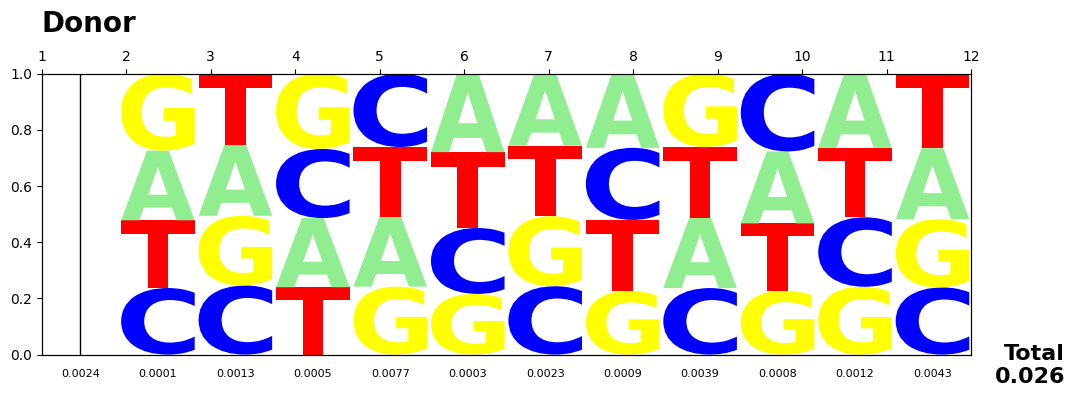

In [143]:
# --- 1) Normalize counts → frequencies ---
counts = donor_with_bits[['A','C','G','T']]
freqs  = counts.div(counts.sum(axis=1), axis=0)

# --- 2) Set up colors and positions ---
colors = {'A':'lightgreen', 'C':'blue', 'G':'yellow', 'T':'red'}
positions = freqs.index.astype(str).tolist()

# --- 3) Plot with Logomaker ---
fig, ax = plt.subplots(figsize=(10,4))
logo = logomaker.Logo(
    freqs,
    ax=ax,
    shade_below=.5,
    fade_below=.5,
    color_scheme=colors
)

# Boundary between exon/intron at x=0
ax.axvline(x=0, color='black', linewidth=1)

# Top axis for positions
ax_top = ax.twiny()
ax_top.set_xticks(range(len(positions)))
ax_top.set_xticklabels(positions)
ax_top.xaxis.set_ticks_position('top')

# Bits annotations under each stack
ymin, _ = ax.get_ylim()
for i, pos in enumerate(freqs.index):
    b = donor_with_bits.at[pos, 'bits']
    ax.text(i, ymin - 0.05, f"{b:.4f}", ha='center', va='top', fontsize=8)

# Legend for total bits
total_bits = donor_with_bits['bits'].sum()
fig.text(
    1.07, 0.02,           # x, y in figure fraction coordinates (bottom‑right outside axes)
    f"Total\n{total_bits:.3f}",
    ha='right', va='bottom',
    fontsize=16,
    fontweight='bold'
)

ax.set_title('Donor', loc='left', fontsize=20, fontweight='bold', pad=30)
# ax.set_ylabel('Frequency')
ax.set_xlabel('')
ax.set_xticks([])  # hide bottom ticks
ax.set_xlim(-0.5, len(positions)-0.5)
plt.tight_layout()
plt.show()

### 3.4 Plot Acceptor

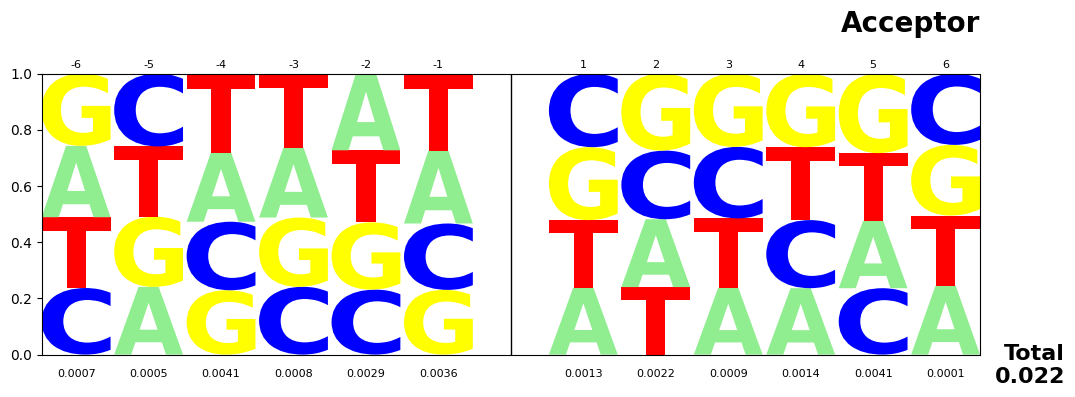

In [142]:
counts = acceptor_with_bits[['A','C','G','T']]
freqs  = counts.div(counts.sum(axis=1), axis=0)

colors = {'A':'lightgreen', 'C':'blue', 'G':'yellow', 'T':'red'}
positions = freqs.index.astype(str).tolist()

fig, ax = plt.subplots(figsize=(10,4))
logo = logomaker.Logo(
    freqs,
    ax=ax,
    shade_below=0.5,
    fade_below=0.5,
    color_scheme=colors
)

# Boundary between exon/intron at x=0
ax.axvline(x=0, color='black', linewidth=1)

# Top axis for positions
_, ymax = ax.get_ylim()
for i, pos in enumerate(freqs.index):
    ax.text(pos, ymax + 0.05, f"{pos}", ha='center', va='top', fontsize=8)


# Bits annotations under each stack
ymin, _ = ax.get_ylim()
for i, pos in enumerate(freqs.index):

    b = acceptor_with_bits.at[pos, 'bits']
    ax.text(pos, ymin - 0.05, f"{b:.4f}", ha='center', va='top', fontsize=8)

# Legend for total bits
total_bits = acceptor_with_bits['bits'].sum()
fig.text(
    1.07, 0.02,           # x, y in figure fraction coordinates (bottom‑right outside axes)
    f"Total\n{total_bits:.3f}",
    ha='right', va='bottom',
    fontsize=16,
    fontweight='bold'
)

ax.set_title('Acceptor', loc='right', fontsize=20, fontweight='bold', pad=30)
ax.set_xlabel('')
ax.set_xticks([])  # hide bottom ticks
# ax.set_xlim(-0.5, len(positions)-0.5)
plt.tight_layout()
plt.show()